In [6]:
#|default_exp augment

# Augmentation

In [7]:
pip install torcheval

Note: you may need to restart the kernel to use updated packages.


In [8]:
#|export
import torch,random
import fastcore.all as fc

from torch import nn
from torch.nn import init

from miniai.datasets import *
from miniai.conv import *
from miniai.learner import *
from miniai.activations import *
from miniai.init import *
from miniai.sgd import *
from miniai.resnet import *

In [9]:
import pickle,gzip,math,os,time,shutil
import matplotlib as mpl,numpy as np,matplotlib.pyplot as plt
from collections.abc import Mapping
from pathlib import Path
from operator import attrgetter,itemgetter
from functools import partial
from copy import copy
from contextlib import contextmanager

import torchvision.transforms.functional as TF,torch.nn.functional as F
from torch import tensor,optim
from torch.utils.data import DataLoader,default_collate
from torch.optim import lr_scheduler
from torcheval.metrics import MulticlassAccuracy
from datasets import load_dataset,load_dataset_builder

from fastcore.test import test_close
from torch import distributions

torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)
torch.manual_seed(1)
mpl.rcParams['image.cmap'] = 'gray_r'

import logging
logging.disable(logging.WARNING)

set_seed(42)

if fc.defaults.cpus>8: fc.defaults.cpus=8

In [10]:
xl,yl = 'image','label'
name = "fashion_mnist"
bs = 1024
xmean,xstd = 0.28, 0.35

@inplace
def transformi(b): b[xl] = [(TF.to_tensor(o)-xmean)/xstd for o in b[xl]]

dsd = load_dataset(name)
tds = dsd.with_transform(transformi)
dls = DataLoaders.from_dd(tds, bs, num_workers=fc.defaults.cpus)

  0%|          | 0/2 [00:00<?, ?it/s]

In [11]:
metrics = MetricsCB(accuracy=MulticlassAccuracy())
astats = ActivationStats(fc.risinstance(GeneralRelu))
cbs = [DeviceCB(), metrics, ProgressCB(plot=True), astats]
act_gr = partial(GeneralRelu, leak=0.1, sub=0.4)
iw = partial(init_weights, leaky=0.1)

In [12]:
set_seed(42)
lr,epochs = 6e-2,5

## Going wider

In [13]:
def get_model(act=nn.ReLU, nfs=(16,32,64,128,256,512), norm=nn.BatchNorm2d):
    layers = [ResBlock(1, 16, ks=5, stride=1, act=act, norm=norm)]
    layers += [ResBlock(nfs[i], nfs[i+1], act=act, norm=norm, stride=2) for i in range(len(nfs)-1)]
    layers += [nn.Flatten(), nn.Linear(nfs[-1], 10, bias=False), nn.BatchNorm1d(10)]
    return nn.Sequential(*layers)

In [14]:
lr = 1e-2
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
xtra = [BatchSchedCB(sched)]
model = get_model(act_gr, norm=nn.BatchNorm2d).apply(iw)
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)

accuracy,loss,epoch,train
0.824,0.704,0,train
0.851,0.610,0,eval
0.898,0.381,1,train
0.882,0.373,1,eval
0.921,0.266,2,train
0.903,0.299,2,eval
0.942,0.195,3,train
0.928,0.239,3,eval
0.963,0.139,4,train
0.933,0.224,4,eval


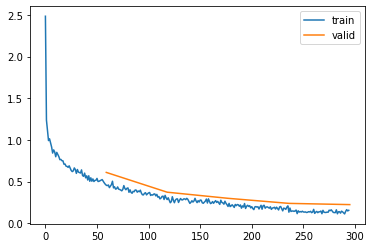

In [15]:
learn.fit(epochs)

### Pooling

In [16]:
class GlobalAvgPool(nn.Module):
    def forward(self, x): return x.mean((-2,-1))

In [17]:
def get_model2(act=nn.ReLU, nfs=(16,32,64,128,256), norm=nn.BatchNorm2d):
    layers = [ResBlock(1, 16, ks=5, stride=1, act=act, norm=norm)]
    layers += [ResBlock(nfs[i], nfs[i+1], act=act, norm=norm, stride=2) for i in range(len(nfs)-1)]
    layers += [ResBlock(256, 512, act=act, norm=norm), GlobalAvgPool()]
    layers += [nn.Linear(512, 10, bias=False), nn.BatchNorm1d(10)]
    return nn.Sequential(*layers)

In [18]:
#|export
def _flops(x, h, w):
    if x.dim()<3: return x.numel()
    if x.dim()==4: return x.numel()*h*w

@fc.patch
def summary(self:Learner):
    res = '|Module|Input|Output|Num params|MFLOPS|\n|--|--|--|--|--|\n'
    totp,totf = 0,0
    def _f(hook, mod, inp, outp):
        nonlocal res,totp,totf
        nparms = sum(o.numel() for o in mod.parameters())
        totp += nparms
        *_,h,w = outp.shape
        flops = sum(_flops(o, h, w) for o in mod.parameters())/1e6
        totf += flops
        res += f'|{type(mod).__name__}|{tuple(inp[0].shape)}|{tuple(outp.shape)}|{nparms}|{flops:.1f}|\n'
    with Hooks(self.model, _f) as hooks: self.fit(1, lr=1, cbs=SingleBatchCB())
    print(f"Tot params: {totp}; MFLOPS: {totf:.1f}")
    if fc.IN_NOTEBOOK:
        from IPython.display import Markdown
        return Markdown(res)
    else: print(res)

In [19]:
TrainLearner(get_model2(), dls, F.cross_entropy, lr=lr, cbs=[DeviceCB()]).summary()

Tot params: 4907588; MFLOPS: 33.0


|Module|Input|Output|Num params|MFLOPS|
|--|--|--|--|--|
|ResBlock|(1024, 1, 28, 28)|(1024, 16, 28, 28)|6928|5.3|
|ResBlock|(1024, 16, 28, 28)|(1024, 32, 14, 14)|14560|2.8|
|ResBlock|(1024, 32, 14, 14)|(1024, 64, 7, 7)|57792|2.8|
|ResBlock|(1024, 64, 7, 7)|(1024, 128, 4, 4)|230272|3.7|
|ResBlock|(1024, 128, 4, 4)|(1024, 256, 2, 2)|919296|3.7|
|ResBlock|(1024, 256, 2, 2)|(1024, 512, 2, 2)|3673600|14.7|
|GlobalAvgPool|(1024, 512, 2, 2)|(1024, 512)|0|0.0|
|Linear|(1024, 512)|(1024, 10)|5120|0.0|
|BatchNorm1d|(1024, 10)|(1024, 10)|20|0.0|


accuracy,loss,epoch,train
0.822,0.715,0,train
0.855,0.552,0,eval
0.897,0.385,1,train
0.880,0.391,1,eval
0.919,0.272,2,train
0.898,0.310,2,eval
0.941,0.198,3,train
0.926,0.243,3,eval
0.962,0.142,4,train
0.930,0.228,4,eval


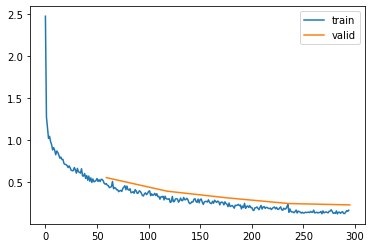

In [20]:
set_seed(42)
model = get_model2(act_gr, norm=nn.BatchNorm2d).apply(iw)
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)
learn.fit(epochs)

In [21]:
# lets try to reduce the mem requiremtns (params) and compute (flops)
def get_model3(act=nn.ReLU, nfs=(16,32,64,128,256), norm=nn.BatchNorm2d):
    layers = [ResBlock(1, 16, ks=5, stride=1, act=act, norm=norm)]
    layers += [ResBlock(nfs[i], nfs[i+1], act=act, norm=norm, stride=2) for i in range(len(nfs)-1)]
    # removed the line of code to 512
    layers += [GlobalAvgPool(), nn.Linear(256, 10, bias=False), nn.BatchNorm1d(10)]
    return nn.Sequential(*layers)

In [22]:
TrainLearner(get_model3(), dls, F.cross_entropy, lr=lr, cbs=[DeviceCB()]).summary()

Tot params: 1231428; MFLOPS: 18.3


|Module|Input|Output|Num params|MFLOPS|
|--|--|--|--|--|
|ResBlock|(1024, 1, 28, 28)|(1024, 16, 28, 28)|6928|5.3|
|ResBlock|(1024, 16, 28, 28)|(1024, 32, 14, 14)|14560|2.8|
|ResBlock|(1024, 32, 14, 14)|(1024, 64, 7, 7)|57792|2.8|
|ResBlock|(1024, 64, 7, 7)|(1024, 128, 4, 4)|230272|3.7|
|ResBlock|(1024, 128, 4, 4)|(1024, 256, 2, 2)|919296|3.7|
|GlobalAvgPool|(1024, 256, 2, 2)|(1024, 256)|0|0.0|
|Linear|(1024, 256)|(1024, 10)|2560|0.0|
|BatchNorm1d|(1024, 10)|(1024, 10)|20|0.0|


In [30]:
[o.shape for o in get_model3()[0].parameters()]

[torch.Size([16, 1, 5, 5]),
 torch.Size([16]),
 torch.Size([16]),
 torch.Size([16]),
 torch.Size([16, 16, 5, 5]),
 torch.Size([16]),
 torch.Size([16]),
 torch.Size([16]),
 torch.Size([16, 1, 1, 1]),
 torch.Size([16])]

accuracy,loss,epoch,train
0.810,0.758,0,train
0.851,0.479,0,eval
0.894,0.402,1,train
0.900,0.335,1,eval
0.920,0.273,2,train
0.900,0.311,2,eval
0.940,0.205,3,train
0.926,0.240,3,eval
0.961,0.149,4,train
0.929,0.228,4,eval


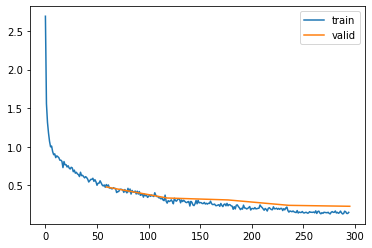

In [24]:
set_seed(42)
model = get_model3(act_gr, norm=nn.BatchNorm2d).apply(iw)
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)
learn.fit(epochs)

In [25]:
def get_model4(act=nn.ReLU, nfs=(16,32,64,128,256), norm=nn.BatchNorm2d):
    layers = [conv(1, 16, ks=5, stride=1, act=act, norm=norm)]
    layers += [ResBlock(nfs[i], nfs[i+1], act=act, norm=norm, stride=2) for i in range(len(nfs)-1)]
    layers += [GlobalAvgPool(), nn.Linear(256, 10, bias=False), nn.BatchNorm1d(10)]
    return nn.Sequential(*layers)

In [26]:
[o.shape for o in get_model4()[0].parameters()]

[torch.Size([16, 1, 5, 5]),
 torch.Size([16]),
 torch.Size([16]),
 torch.Size([16])]

In [27]:
TrainLearner(get_model4(), dls, F.cross_entropy, lr=lr, cbs=[DeviceCB()]).summary()

Tot params: 1224948; MFLOPS: 13.3


|Module|Input|Output|Num params|MFLOPS|
|--|--|--|--|--|
|Sequential|(1024, 1, 28, 28)|(1024, 16, 28, 28)|448|0.3|
|ResBlock|(1024, 16, 28, 28)|(1024, 32, 14, 14)|14560|2.8|
|ResBlock|(1024, 32, 14, 14)|(1024, 64, 7, 7)|57792|2.8|
|ResBlock|(1024, 64, 7, 7)|(1024, 128, 4, 4)|230272|3.7|
|ResBlock|(1024, 128, 4, 4)|(1024, 256, 2, 2)|919296|3.7|
|GlobalAvgPool|(1024, 256, 2, 2)|(1024, 256)|0|0.0|
|Linear|(1024, 256)|(1024, 10)|2560|0.0|
|BatchNorm1d|(1024, 10)|(1024, 10)|20|0.0|


accuracy,loss,epoch,train
0.804,0.782,0,train
0.871,0.481,0,eval
0.898,0.392,1,train
0.890,0.369,1,eval
0.918,0.278,2,train
0.908,0.295,2,eval
0.941,0.202,3,train
0.925,0.242,3,eval
0.961,0.148,4,train
0.927,0.234,4,eval


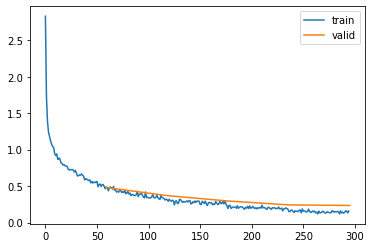

In [28]:
set_seed(42)
model = get_model4(act_gr, norm=nn.BatchNorm2d).apply(iw)
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)
learn.fit(epochs)

## Data augmentation

After 20 epochs without augmentation:

```
{'accuracy': '0.999', 'loss': '0.012', 'epoch': 19, 'train': True}
{'accuracy': '0.924', 'loss': '0.284', 'epoch': 19, 'train': False}
```

With batchnorm, weight decay doesn't really regularize.

In [20]:
from torchvision import transforms

In [21]:
def tfm_batch(b, tfm_x=fc.noop, tfm_y = fc.noop): return tfm_x(b[0]),tfm_y(b[1])

tfms = nn.Sequential(transforms.RandomCrop(28, padding=4),
                     transforms.RandomHorizontalFlip())

augcb = BatchTransformCB(partial(tfm_batch, tfm_x=tfms), on_val=False)
model = get_model()
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=[SingleBatchCB(), augcb])

In [22]:
learn.fit(1)

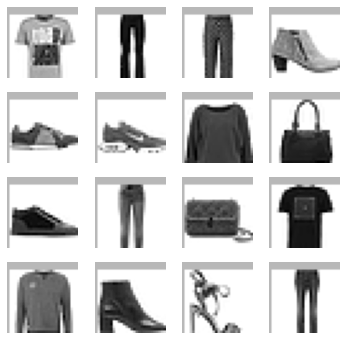

In [25]:
xb,yb = learn.batch
show_images(xb[:16], imsize=1.5)

In [26]:
#| export
@fc.patch
@fc.delegates(show_images)
def show_image_batch(self:Learner, max_n=9, cbs=None, **kwargs):
    self.fit(1, cbs=[SingleBatchCB()]+fc.L(cbs))
    show_images(self.batch[0][:max_n], **kwargs)

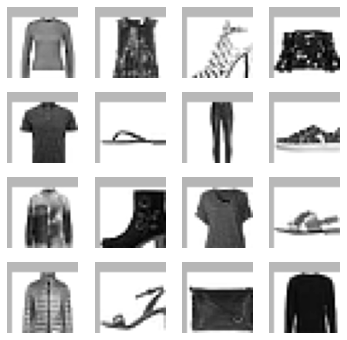

In [27]:
learn.show_image_batch(max_n=16, imsize=(1.5))

In [ ]:
tfms = nn.Sequential(transforms.RandomCrop(28, padding=1),
                     transforms.RandomHorizontalFlip())
augcb = BatchTransformCB(partial(tfm_batch, tfm_x=tfms), on_val=False)

accuracy,loss,epoch,train
0.762,0.890,0,train
0.805,0.633,0,eval
0.857,0.602,1,train
0.854,0.499,1,eval
0.877,0.479,2,train
0.863,0.422,2,eval
0.885,0.399,3,train
0.882,0.356,3,eval
0.896,0.332,4,train
0.892,0.329,4,eval


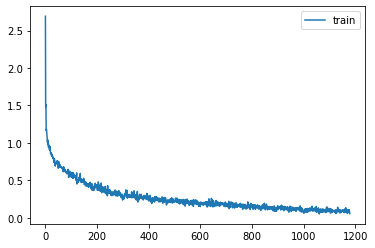

In [ ]:
set_seed(42)
epochs = 20
lr = 1e-2
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
xtra = [BatchSchedCB(sched), augcb]
model = get_model(act_gr, norm=nn.BatchNorm2d).apply(iw)
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)
learn.fit(epochs)

A custom collation function could let you do per-item transformations.

In [ ]:
mdl_path = Path('models')
mdl_path.mkdir(exist_ok=True)
torch.save(learn.model, mdl_path/'data_aug.pkl')

## Test time augmentation (TTA)

In [32]:
#| export
class CapturePreds(Callback):
    def before_fit(self, learn): self.all_inps,self.all_preds,self.all_targs = [],[],[]
    def after_batch(self, learn):
        self.all_inps.append(to_cpu(learn.batch[0]))
        self.all_preds.append(to_cpu(learn.preds))
        self.all_targs.append(to_cpu(learn.batch[1]))
    def after_fit(self, learn):
        self.all_preds,self.all_targs,self.all_inps = map(torch.cat, [self.all_preds,self.all_targs,self.all_inps])

In [33]:
#| export
@fc.patch
def capture_preds(self: Learner, cbs=None, inps=False):
    cp = CapturePreds()
    self.fit(1, train=False, cbs=[cp]+fc.L(cbs))
    res = cp.all_preds,cp.all_targs
    if inps: res = res+(cp.all_inps,)
    return res

In [34]:
ap1, at = learn.capture_preds()

In [35]:
ttacb = BatchTransformCB(partial(tfm_batch, tfm_x=TF.hflip), on_val=True)
ap2, at = learn.capture_preds(cbs=[ttacb])

In [36]:
ap1.shape,ap2.shape,at.shape

AttributeError: 'list' object has no attribute 'shape'

In [ ]:
ap = torch.stack([ap1,ap2]).mean(0).argmax(1)

In [ ]:
round((ap==at).float().mean().item(), 3)

## Random erase

In [56]:
xb,_ = next(iter(dls.train))
xbt = xb[:16]

In [57]:
xm,xs = xbt.mean(),xbt.std()

In [58]:
xbt.min(), xbt.max()

(tensor(-0.80), tensor(2.06))

In [59]:
pct = 0.2

In [60]:
szx = int(pct*xbt.shape[-2])
szy = int(pct*xbt.shape[-1])
stx = int(random.random()*(1-pct)*xbt.shape[-2])
sty = int(random.random()*(1-pct)*xbt.shape[-1])
stx,sty,szx,szy

(16, 15, 5, 5)

In [61]:
init.normal_(xbt[:,:,stx:stx+szx,sty:sty+szy], mean=xm, std=xs);

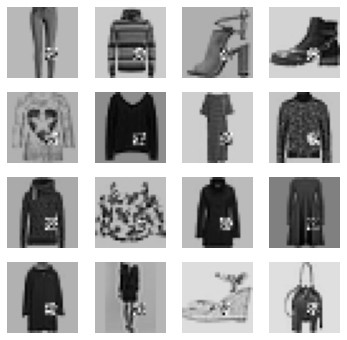

In [62]:
show_images(xbt, imsize=1.5)

In [63]:
xbt.min(), xbt.max()

(tensor(-3.65), tensor(2.94))

In [66]:
#|export
def _rand_erase1(x, pct, xm, xs, mn, mx):
    szx = int(pct*x.shape[-2])
    szy = int(pct*x.shape[-1])
    stx = int(random.random()*(1-pct)*x.shape[-2])
    sty = int(random.random()*(1-pct)*x.shape[-1])
    init.normal_(x[:,:,stx:stx+szx,sty:sty+szy], mean=xm, std=xs)
    x.clamp_(mn, mx)

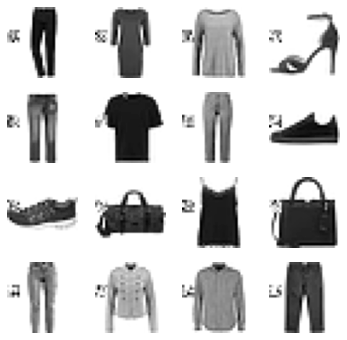

In [67]:
xb,_ = next(iter(dls.train))
xbt = xb[:16]
_rand_erase1(xbt, 0.2, xbt.mean(), xbt.std(), xbt.min(), xbt.max())
show_images(xbt, imsize=1.5)

In [68]:
xbt.mean(),xbt.std(),xbt.min(), xbt.max()

(tensor(0.04), tensor(1.01), tensor(-0.80), tensor(2.06))

In [69]:
#|export
def rand_erase(x, pct=0.2, max_num = 4):
    xm,xs,mn,mx = x.mean(),x.std(),x.min(),x.max()
    num = random.randint(0, max_num)
    for i in range(num): _rand_erase1(x, pct, xm, xs, mn, mx)
#     print(num)
    return x

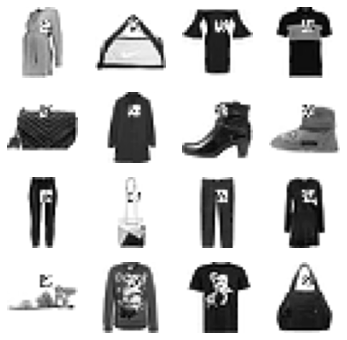

In [70]:
xb,_ = next(iter(dls.train))
xbt = xb[:16]
rand_erase(xbt, 0.2, 4)
show_images(xbt, imsize=1.5)

In [71]:
#|export
class RandErase(nn.Module):
    def __init__(self, pct=0.2, max_num=4):
        super().__init__()
        self.pct,self.max_num = pct,max_num
    def forward(self, x): return rand_erase(x, self.pct, self.max_num)

In [72]:
tfms = nn.Sequential(transforms.RandomCrop(28, padding=1),
                     transforms.RandomHorizontalFlip(),
                     RandErase())
augcb = BatchTransformCB(partial(tfm_batch, tfm_x=tfms), on_val=False)

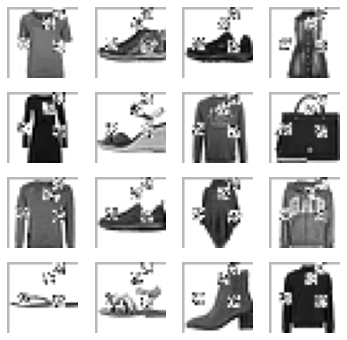

In [73]:
model = get_model()
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=[DeviceCB(), SingleBatchCB(), augcb])
learn.fit(1)
xb,yb = learn.batch
show_images(xb[:16], imsize=1.5)

accuracy,loss,epoch,train
0.764,0.875,0,train
0.813,0.622,0,eval
0.842,0.625,1,train
0.850,0.552,1,eval
0.861,0.537,2,train
0.864,0.446,2,eval
0.869,0.468,3,train
0.855,0.461,3,eval
0.873,0.422,4,train
0.861,0.435,4,eval


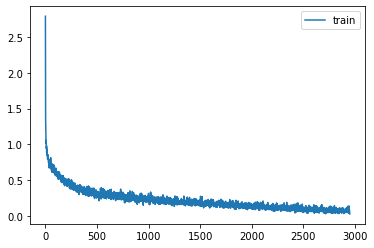

In [ ]:
epochs = 50
lr = 2e-2
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
xtra = [BatchSchedCB(sched), augcb]
model = get_model(act_gr, norm=nn.BatchNorm2d).apply(iw)
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)
learn.fit(epochs)

## Random copy

In [74]:
xb,_ = next(iter(dls.train))
xbt = xb[:16]

In [75]:
szx = int(pct*xbt.shape[-2])
szy = int(pct*xbt.shape[-1])
stx1 = int(random.random()*(1-pct)*xbt.shape[-2])
sty1 = int(random.random()*(1-pct)*xbt.shape[-1])
stx2 = int(random.random()*(1-pct)*xbt.shape[-2])
sty2 = int(random.random()*(1-pct)*xbt.shape[-1])
stx1,sty1,stx2,sty2,szx,szy

(15, 7, 3, 21, 5, 5)

In [76]:
xbt[:,:,stx1:stx1+szx,sty1:sty1+szy] = xbt[:,:,stx2:stx2+szx,sty2:sty2+szy]

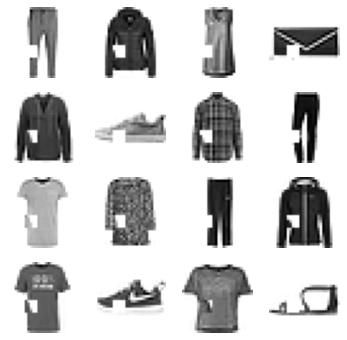

In [77]:
show_images(xbt, imsize=1.5)

In [78]:
#|export
def _rand_copy1(x, pct):
    szx = int(pct*x.shape[-2])
    szy = int(pct*x.shape[-1])
    stx1 = int(random.random()*(1-pct)*x.shape[-2])
    sty1 = int(random.random()*(1-pct)*x.shape[-1])
    stx2 = int(random.random()*(1-pct)*x.shape[-2])
    sty2 = int(random.random()*(1-pct)*x.shape[-1])
    x[:,:,stx1:stx1+szx,sty1:sty1+szy] = x[:,:,stx2:stx2+szx,sty2:sty2+szy]

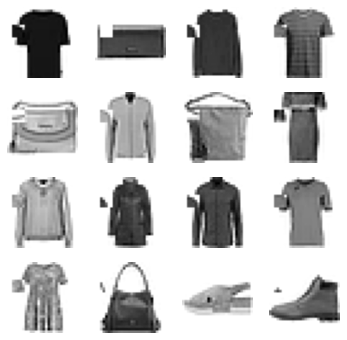

In [79]:
xb,_ = next(iter(dls.train))
xbt = xb[:16]
_rand_copy1(xbt, 0.2)
show_images(xbt, imsize=1.5)

In [80]:
#|export
def rand_copy(x, pct=0.2, max_num = 4):
    num = random.randint(0, max_num)
    for i in range(num): _rand_copy1(x, pct)
#     print(num)
    return x

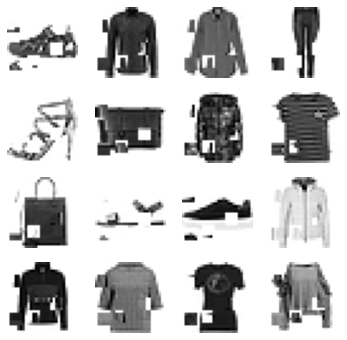

In [81]:
xb,_ = next(iter(dls.train))
xbt = xb[:16]
rand_copy(xbt, 0.2, 4)
show_images(xbt, imsize=1.5)

In [82]:
#|export
class RandCopy(nn.Module):
    def __init__(self, pct=0.2, max_num=4):
        super().__init__()
        self.pct,self.max_num = pct,max_num
    def forward(self, x): return rand_copy(x, self.pct, self.max_num)

In [83]:
tfms = nn.Sequential(transforms.RandomCrop(28, padding=1),
                     transforms.RandomHorizontalFlip(),
                     RandCopy())
augcb = BatchTransformCB(partial(tfm_batch, tfm_x=tfms), on_val=False)

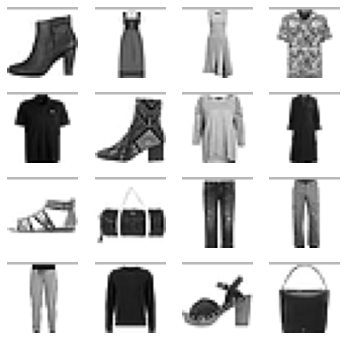

In [84]:
model = get_model()
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=[DeviceCB(), SingleBatchCB(), augcb])
learn.fit(1)
xb,yb = learn.batch
show_images(xb[:16], imsize=1.5)

accuracy,loss,epoch,train
0.738,0.944,0,train
0.813,0.605,0,eval
0.832,0.667,1,train
0.835,0.553,1,eval
0.848,0.570,2,train
0.822,0.528,2,eval
0.858,0.490,3,train
0.833,0.532,3,eval
0.870,0.419,4,train
0.866,0.403,4,eval


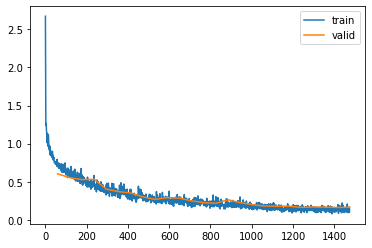

In [85]:
set_seed(1)
epochs = 25
lr = 1e-2
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
xtra = [BatchSchedCB(sched), augcb]
model = get_model(act_gr, norm=nn.BatchNorm2d).apply(iw)
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)
learn.fit(epochs)

accuracy,loss,epoch,train
0.743,0.932,0,train
0.807,0.621,0,eval
0.831,0.670,1,train
0.823,0.585,1,eval
0.854,0.558,2,train
0.855,0.480,2,eval
0.865,0.478,3,train
0.875,0.404,3,eval
0.876,0.402,4,train
0.882,0.366,4,eval


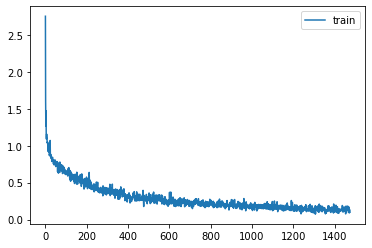

In [ ]:
model2 = get_model(act_gr, norm=nn.BatchNorm2d).apply(iw)
learn2 = TrainLearner(model2, dls, F.cross_entropy, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)
learn2.fit(epochs)

In [ ]:
mdl_path = Path('models')
torch.save(learn.model,  mdl_path/'randcopy1.pkl')
torch.save(learn2.model, mdl_path/'randcopy2.pkl')

In [ ]:
cp1 = CapturePreds()
learn.fit(1, train=False, cbs=cp1)

accuracy,loss,epoch,train
0.944,0.163,0,eval


In [ ]:
cp2 = CapturePreds()
learn2.fit(1, train=False, cbs=cp2)

accuracy,loss,epoch,train
0.944,0.166,0,eval


In [ ]:
ap = torch.stack([cp1.all_preds,cp2.all_preds]).mean(0).argmax(1)

In [ ]:
round((ap==cp1.all_targs).float().mean().item(), 3)

0.947

## Dropout

In [ ]:
p = 0.1
dist = distributions.binomial.Binomial(probs=1-p)
dist.sample((10,))

tensor([1., 0., 1., 1., 1., 1., 1., 1., 1., 1.])

In [ ]:
class Dropout(nn.Module):
    def __init__(self, p=0.1):
        super().__init__()
        self.p = p

    def forward(self, x):
        if not self.training: return x
        dist = distributions.binomial.Binomial(tensor(1.0).to(x.device), probs=1-self.p)
        return x * dist.sample(x.size()) * 1/(1-self.p)

In [ ]:
def get_dropmodel(act=nn.ReLU, nfs=(16,32,64,128,256,512), norm=nn.BatchNorm2d, drop=0.0):
    layers = [ResBlock(1, 16, ks=5, stride=1, act=act, norm=norm), nn.Dropout2d(drop)]
    layers += [ResBlock(nfs[i], nfs[i+1], act=act, norm=norm, stride=2) for i in range(len(nfs)-1)]
    layers += [nn.Flatten(), Dropout(drop), nn.Linear(nfs[-1], 10, bias=False), nn.BatchNorm1d(10)]
    return nn.Sequential(*layers)

In [ ]:
set_seed(42)
epochs=5
lr = 1e-2
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
xtra = [BatchSchedCB(sched)]
model = get_dropmodel(act_gr, norm=nn.BatchNorm2d, drop=0.1).apply(iw)
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)

accuracy,loss,epoch,train
0.809,0.746,0,train
0.829,0.557,0,eval
0.892,0.396,1,train
0.882,0.350,1,eval
0.916,0.280,2,train
0.911,0.284,2,eval
0.937,0.209,3,train
0.924,0.242,3,eval
0.956,0.157,4,train
0.932,0.223,4,eval


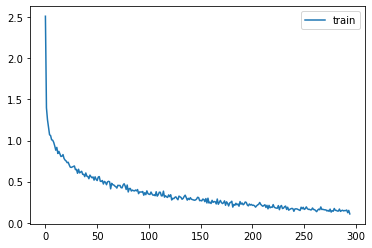

In [ ]:
learn.fit(epochs)

In [ ]:
class TTD_CB(Callback):
    def before_epoch(self, learn):
        learn.model.apply(lambda m: m.train() if isinstance(m, (nn.Dropout,nn.Dropout2d)) else None)

## Augment 2

In [ ]:
@inplace
def transformi(b): b[xl] = [(TF.to_tensor(o)*2-1) for o in b[xl]]

tds = dsd.with_transform(transformi)
dls = DataLoaders.from_dd(tds, bs, num_workers=fc.defaults.cpus)

accuracy,loss,epoch,train
0.762,0.885,0,train
0.826,0.592,0,eval
0.853,0.608,1,train
0.851,0.511,1,eval
0.869,0.494,2,train
0.867,0.409,2,eval
0.883,0.402,3,train
0.885,0.355,3,eval
0.894,0.337,4,train
0.843,0.457,4,eval


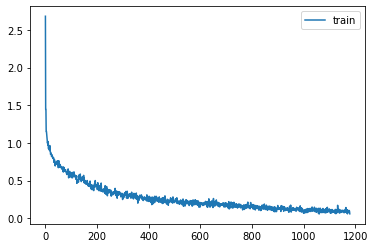

In [ ]:
set_seed(42)
epochs = 20
lr = 1e-2
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
xtra = [BatchSchedCB(sched), augcb]
model = get_model(act_gr, norm=nn.BatchNorm2d).apply(iw)
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)
learn.fit(epochs)

In [ ]:
torch.save(learn.model, 'models/data_aug2.pkl')

### Export -

In [ ]:
import nbdev; nbdev.nbdev_export()